### nb2d
Conversion Stuff

In [1]:
#@EXCLUDE@
import_tag = "#@EXPORT imports"
non_task_code_tag = "#@EXPORT non_task_code"
data_ingest_task_tag = "#@EXPORT data_ingest_task"
model_training_task_tag = "#@EXPORT model_training_task"
model_deployment_task_tag = "#@EXPORT model_deployment_task"
tasks_list = [data_ingest_task_tag, model_training_task_tag, model_deployment_task_tag]

## Data Ingest

In [2]:
#@EXPORT imports
import csv, sqlite3
import pandas as pd
import numpy as np
import os

#### Read in CSV file

In [3]:
#@EXPORT data_ingest_task
telco_data_csv = pd.read_csv('https://raw.githubusercontent.com/fletchjeff/COPML-1_telco_churn/main/data/WA_Fn-UseC_-Telco-Customer-Churn-.csv')

In [4]:
telco_data_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
telco_data_csv.head(2)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No


#### Clean the Data
There are a few things that need to fixed in this CSV file. First issue is that `Total Charges` should be numeric, but its not.

```TotalCharges      7043 non-null   object ```

That is fixed below. 

In [6]:
#@EXPORT data_ingest_task
telco_data_csv["TotalCharges"] = pd.to_numeric(telco_data_csv["TotalCharges"],errors='coerce')

Next is the `SeniorCitzen` field, which is 0 or 1, not "Yes" / "No" like the other categorical fields.

In [7]:
#@EXPORT data_ingest_task
telco_data_csv = telco_data_csv.replace({'SeniorCitizen': {1: 'Yes', 0: 'No'}})

Last step is to drop any rows that have bad data.

In [8]:
#@EXPORT data_ingest_task
telco_data_csv = telco_data_csv.replace(r'^\s$', np.nan, regex=True).dropna().reset_index().drop(columns=['index'])

#### Write data to database (SQLite)

In [9]:
#@EXPORT data_ingest_task
con = sqlite3.connect("churn_data.db")

In [10]:
#@EXPORT data_ingest_task
telco_data_csv.to_sql("telco_data_labeled",con=con,if_exists='replace',index=False)

7032

In [11]:
# This is a handy way of seeing the tables in your SQLite table
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('telco_data_unlabeled',), ('telco_data_labeled',)]


### Generate Fake Data
This next step is only necessary in this Notebook as there isn't any unlabled data in the example data set. 

In [12]:
#@EXPORT non_task_code
con = sqlite3.connect("churn_data.db")
telco_data = pd.read_sql_query("SELECT * from telco_data_labeled", con)

In [13]:
categorical_columns = [ 
    "gender",
    "SeniorCitizen",
    "Partner",
    "Dependents",
    "PhoneService",
    "MultipleLines",
    "InternetService",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
    "Contract",
    "PaperlessBilling",
    "PaymentMethod"
]

numeric_columns = [
    "tenure",
    "TotalCharges",
    "MonthlyCharges"
]

In [14]:
import string
import random
new_data_list = []
for i in range(1000):
    new_data_row = {}
    cust_id_string = ""
    for i in range(4):
        cust_id_string += str(random.randint(0,9))
    cust_id_string += "-"
    for i in range(5):
        cust_id_string += random.choice(string.ascii_letters[26:])
    new_data_row['customerID'] = cust_id_string
    for column in list(telco_data.columns):
        if column in categorical_columns:
            columm_dict = telco_data.groupby(column).size().to_dict()
            new_data_row[column] = random.choices(list(columm_dict.keys()), weights = list(columm_dict.values()), k = 1)[0]
        elif column in numeric_columns:
            new_data_row[column] = telco_data[column].sample().to_list()[0]
        else:
            None
    new_data_list.append(new_data_row)
new_data_df = pd.DataFrame(new_data_list)    

In [15]:
new_data_df.head(2)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,2861-RZWLJ,Female,No,Yes,No,48,Yes,No,Fiber optic,Yes,No,No internet service,No,Yes,Month-to-month,Yes,Electronic check,65.2,3952.65
1,4264-IYPTE,Male,Yes,Yes,No,72,Yes,Yes,DSL,Yes,No,No internet service,No,No,Month-to-month,No,Credit card (automatic),75.5,533.50


In [16]:
new_data_df.to_sql("telco_data_unlabeled",con=con,if_exists='replace',index=False)

1000

In [17]:
#@EXPORT non_task_code
con.close()

## Data Exploration

In [18]:
#@EXPORT model_training_dag
con = sqlite3.connect("churn_data.db")
telco_data = pd.read_sql_query("SELECT * from telco_data_labeled", con)

In [19]:
telco_data.groupby(['InternetService']).size()

InternetService
DSL            2416
Fiber optic    3096
No             1520
dtype: int64

In [20]:
total_customers = len(telco_data)
churned_customers = len(telco_data.query("Churn == 'Yes'"))
remain_customers = len(telco_data.query("Churn == 'No'"))

"Customers total: {}, Churned : {}, Remained : {}".format(total_customers, churned_customers, remain_customers)

'Customers total: 7032, Churned : 1869, Remained : 5163'

In [21]:
len(telco_data)

7032

In [22]:
len(telco_data.query("Churn == 'Yes'"))

1869

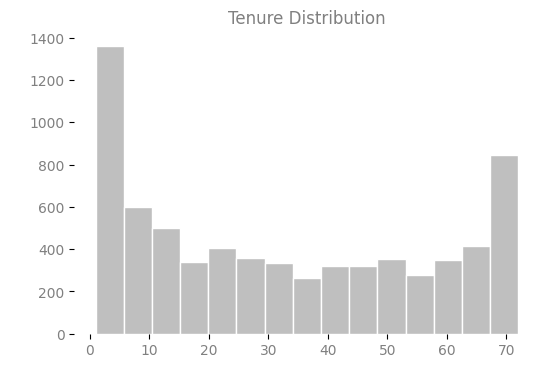

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 100
plt.grid(visible=False)
plt.title("Tenure Distribution",color='grey')
plt.xticks(color='grey')
plt.yticks(color='grey')
plt.xlabel(" ")
plt.ylabel(" ")

sns.set_style("whitegrid")
sns.despine(left=True,bottom=True)

sns.histplot(telco_data['tenure'],color='#aaa')
plt.show()

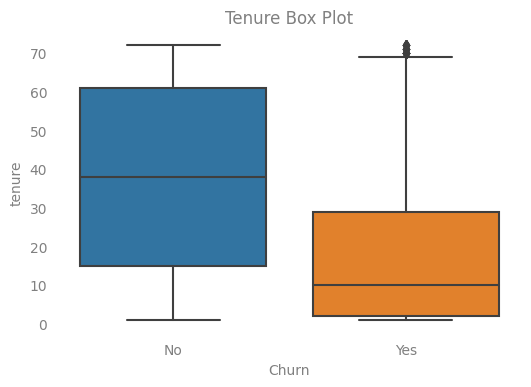

In [24]:
plt.grid(visible=False)
plt.title("Tenure Box Plot",color='grey')
plt.xticks(color='grey')
plt.yticks(color='grey')
plt.xlabel("",color='grey')
plt.ylabel("",color='grey')

sns.set_style("whitegrid")
sns.despine(left=True,bottom=True)

sns.boxplot(x="Churn", y="tenure", data=telco_data)
plt.show()

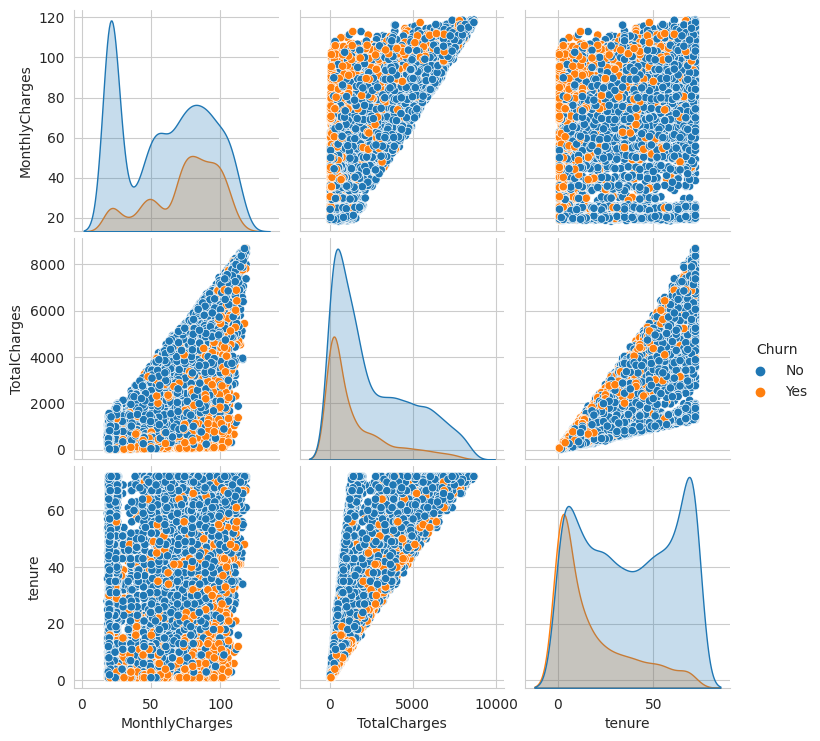

In [25]:
sns.set_style("whitegrid")
example_numeric_data = telco_data[["MonthlyCharges", "TotalCharges","tenure","Churn"]]  # pick a few columns
sns.pairplot(example_numeric_data, hue="Churn")
plt.show()

## Model Building

In [26]:
#@EXPORT model_training_task
import mlflow
from sklearn.model_selection import GridSearchCV

In [27]:
#@EXPORT model_training_task
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.compose import ColumnTransformer

In [28]:
#@EXPORT model_training_task
categorical_columns = [
    "gender",
    "SeniorCitizen",
    "Partner",
    "Dependents",
    "PhoneService",
    "MultipleLines",
    "InternetService",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
    "Contract",
    "PaperlessBilling",
    "PaymentMethod"
]

numeric_columns = [
    "tenure",
    "TotalCharges",
    "MonthlyCharges"
]

In [29]:
#@EXPORT model_training_task
transformation_ct = ColumnTransformer(
    [('ohe', OneHotEncoder(), categorical_columns)],#col_index)],
    remainder='passthrough'
)

In [30]:
#@EXPORT model_training_task
transformation_pipeline = Pipeline(
    [
        ('transformation_ct', transformation_ct),
        ('scaler', StandardScaler())
    ]
)

In [31]:
#@EXPORT model_training_task
import sqlite3
import pandas as pd
con = sqlite3.connect("churn_data.db")

In [32]:
#@EXPORT model_training_task
telco_data = pd.read_sql_query("SELECT * from telco_data_labeled", con)

In [33]:
#@EXPORT model_training_task
X_data = transformation_pipeline.fit_transform(telco_data[categorical_columns+numeric_columns])
y_label = telco_data["Churn"]
X_data_train, X_data_test, y_label_train, y_label_test = train_test_split(
    X_data, y_label, random_state=42
)

In [34]:
from joblib import dump, load
dump(transformation_pipeline, "transformer.joblib")


['transformer.joblib']

In [35]:
churn_model = LogisticRegressionCV(solver='lbfgs')

In [36]:
mlflow.sklearn.autolog(disable=True)
churn_model.fit(X_data_train,y_label_train)

LogisticRegressionCV()

In [37]:
churn_model.score(X_data_train,y_label_train)

0.8067880166856276

In [38]:
churn_model.score(X_data_test, y_label_test)

0.7963594994311718

In [39]:
churn_model.predict([X_data_test[5]])

array(['No'], dtype=object)

## Model Training

In [40]:
churn_model.get_params()

{'Cs': 10,
 'class_weight': None,
 'cv': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1.0,
 'l1_ratios': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'refit': True,
 'scoring': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0}

In [41]:
#@EXPORT model_training_task
from sklearn.model_selection import GridSearchCV
grid_values = {'Cs':[10, 1000], 'cv': [5,10], 'max_iter':[100,150]}

churn_model = LogisticRegressionCV()
churn_model_gridsearch = GridSearchCV(churn_model, param_grid=grid_values,n_jobs=-1)


In [42]:
#@EXPORT model_training_task
#mlflow.set_tracking_uri("http://192.168.1.100:5000")
mlflow.set_experiment("test_notebook")
mlflow.sklearn.autolog() 

In [ ]:
#@EXPORT model_training_task
mlflow.start_run()
churn_model_gridsearch.fit(X_data_train,y_label_train)
latest_run = mlflow.active_run().info.run_id
mlflow.end_run()

In [ ]:
churn_model_gridsearch.score(X_data_train,y_label_train)

In [ ]:
latest_run

### Model Deployment

In [ ]:
#@EXPORT model_deployment_task
import mlflow
logged_model = 'runs:/{}/best_estimator'.format(latest_run)

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

In [ ]:
loaded_model

In [ ]:
#@EXPORT model_deployment_task
import sqlite3
import pandas as pd
con = sqlite3.connect("churn_data.db")

In [ ]:
#@EXPORT model_deployment_task
telco_data_unlabeled = pd.read_sql_query("SELECT * from telco_data_unlabeled", con)

In [ ]:
loaded_model.predict(X_data_test[0].reshape(-1,43))

In [ ]:
telco_data_unlabeled.shape

In [ ]:
#@EXPORT model_deployment_task
from joblib import dump, load
transformation_pipeline = load("transformer.joblib")

In [ ]:
#@EXPORT model_deployment_task
predictions = loaded_model.predict(transformation_pipeline.transform(telco_data_unlabeled).reshape(-1,43))

In [ ]:
#@EXPORT model_deployment_task
telco_data_unlabeled['Churn_Prediction'] = predictions.tolist()

In [ ]:
#@EXPORT model_deployment_task
telco_data_unlabeled.to_sql("telco_data_predicted",con=con,if_exists='replace',index=False)
con.close()

In [ ]:
telco_data_unlabeled[['customerID','Churn_Prediction']].head()

In [ ]:
!python jnb2dag.py